# Transportation Network Analysis in Singapore.ipynb
## Primary Objective: Find 2 optimal routes between 2 locations in Singapore with `osmnx`
* Shortest Distance
* Fastest Route (assuming usual traffice)

## Rationale: Cross-compare results from this notebook with the 2 main optimal routes returned by OneMap.sg API at https://docs.onemap.sg/#search
### Example: Between Point(1.264313825,103.8220734) to Point(1.315495939,103.7645838), spatial data returned by the OneMap API had been visualised using <a href="https://leafletjs.com/reference-1.3.4.html" target="blank">LealetJS</a>
#### Shortest Route and Fastest Route (assuming usual traffice)
<img src="onemap_api_Fastest_Shortest_Routes.png" />

## Ultimate Goal: Using python library `osmnx` for further in-depth route optimisation analysis
OneMap API usage has many limitations, including the inability to perform multi-threading due to limited computational power and limited no. of API calls per user per day. Moreover, only 2-3 routes are returned at most for each API call and no other alternative routes are explored. As such, in the long run it is not realistic to rely soley on OneMap API as a routing service to explore optimal travelling routes in Singapore. This notebook shall first attempt to use the <a href="https://osmnx.readthedocs.io/en/stable/osmnx.html" target="blank">osmnx</a> python library to generate the exact same routes for the above Geometry Coordinates and cross-compare the `distance` and `time` travelled. Type of route shall be `drive` and serves as a control variable.

In [1]:
import multiprocessing as mp
import numpy as np
import osmnx as ox
%matplotlib inline
ox.__version__

'0.16.1'

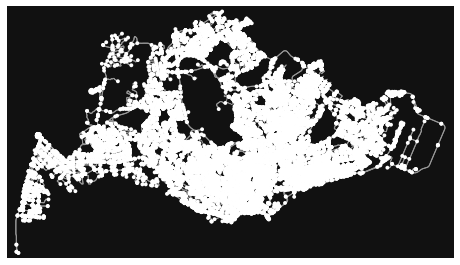

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [2]:
G = ox.graph_from_place('Singapore', network_type='drive')
ox.plot_graph(ox.project_graph(G))

## 1. Fast nearest node/edge search with OSMnx

In [3]:
# convert projected graph to edges geodataframe
gdf_edges = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

In [4]:
# find the nearest node to some point
center_node = ox.get_nearest_node(G, center_point)

In [5]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(G, lngs, lats)

In [6]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(G, lngs, lats)

## 2. Basic routing by distance¶
Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

In [7]:
origin=(1.264313825,103.8220734) #"1.264313825,103.8220734" TELOK BLANGAH ROAD - VIVOCITY
destination=(1.315495939,103.7645838) #"1.315495939,103.7645838" CLEMENTI AVENUE 3 - CLEMENTI MALL

origin_node = ox.graph_from_point(origin)
destination_node = ox.graph_from_point(destination)

In [8]:
G_List = list(G) # all nodes in the graph generated based on Singapore

In [9]:
orig_list=list(origin_node.nodes)
dest_list=list(destination_node.nodes)

In [10]:
orig=list(set(orig_list) & set(G_List))[0] #just pick the 1st as the origin node
orig

4600741378

In [11]:
dest=list(set(dest_list) & set(G_List))[0] #just pick the 1st as the destination node
dest

246294573

### Find the shortest path (by distance) between these nodes then plot it

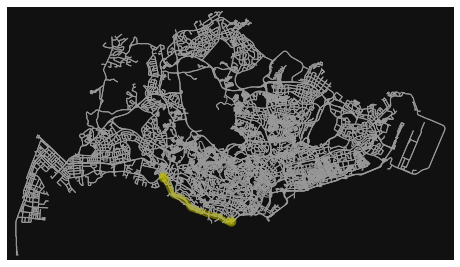

In [12]:
route = ox.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_color='y', route_linewidth=6, node_size=0)

Or get k shortest paths, weighted by some attribute (returns a few possible routes instead of just 1. e.g. 4) - (Optional) 

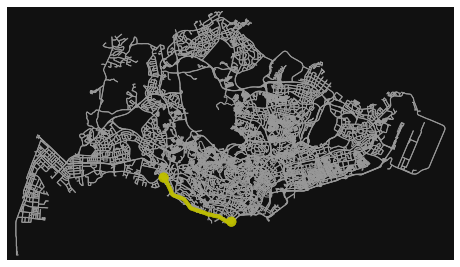

In [13]:
routes = ox.k_shortest_paths(G, orig, dest, k=4, weight='length')
fig_2, ax_2 = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)

## 3. Imputing travel speeds and times

The add_edge_speeds function add edge speeds (km per hour) to graph as new speed_kph edge attributes. Imputes free-flow travel speeds for all edges based on mean maxspeed value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in hwy_speeds and/or fallback arguments that correspond to local speed limit standards. See docstring for details.

In [14]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)
# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [15]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",231.2,50.0,16.6
"['motorway', 'motorway_link']",1075.4,62.5,64.2
"['motorway_link', 'primary']",574.7,70.0,29.6
"['primary_link', 'primary']",2485.3,60.0,149.1
"['residential', 'primary']",21.8,55.0,1.4
"['secondary', 'motorway_link']",873.0,53.1,60.6
"['secondary', 'tertiary']",217.4,60.0,13.0
"['tertiary', 'motorway_link']",412.1,50.0,29.7
"['tertiary', 'residential']",232.6,50.0,16.7


Note: In Singapore, maximum speeds allowed on highways is 90km/h. 

In [16]:
# to fill in edges with missing `maxspeed` from OSM
#hwy_speeds = {
#    'residential': 35,
#    'secondary': 50,
#    'tertiary': 60
#}
# G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.speed.add_edge_speeds(G, hwy_speeds=None, fallback=90, precision=1)
G = ox.speed.add_edge_travel_times(G, precision=1)

In [17]:
orig

4600741378

In [18]:
dest

246294573

In [19]:
# calculate two routes by minimizing travel distance vs travel time
shortest_distance_route = ox.shortest_path(G, orig, dest, weight='length')
fastest_route = ox.shortest_path(G, orig, dest, weight='travel_time')

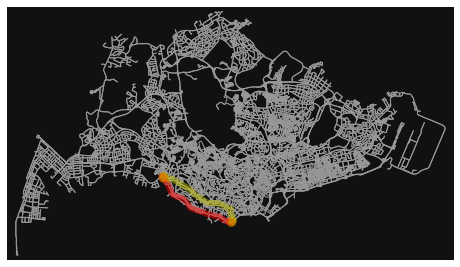

In [20]:
# plot the routes
fig, ax = ox.plot_graph_routes(G, routes=[shortest_distance_route, fastest_route], route_colors=['r', 'y'],
                               route_linewidth=6, 
                               node_size=0
                              )

In [21]:
###### compare the two routes
shortest_distance_route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, shortest_distance_route, 'length')))
fastest_route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, fastest_route, 'length')))
shortest_distance_route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, shortest_distance_route, 'travel_time')))
fastest_route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, fastest_route, 'travel_time')))

print('Shortest Distance Route is', shortest_distance_route_length, 'meters and takes', shortest_distance_route_time, 'seconds.')
print('Fastest Route is', fastest_route_length, 'meters and takes', fastest_route_time, 'seconds.')

Shortest Distance Route is 9909 meters and takes 550 seconds.
Fastest Route is 10570 meters and takes 520 seconds.


The yellow route minimizes travel time but is longer but faster than the red route.

---
## Summary of Results:
### Tables of Comparison:

#### Shortest Route
|Source|Route|Distance|Time Travelled|
|------|-----|------------|-------------------|
|OneMap |Shortest Route|9.84 km|18min 21s|
|OSMnx |Shortest Route|9.91 km|9min 10s|

#### Fastest Route
|Source|Route|Distance|Time Travelled|
|------|-----|------------|-------------------|
|OneMap |Fastest Route|11.53 km|16min 21s|
|OSMnx |Fastest Route|10.57 km|8min 40s|

Note: Constant = Route Type/Network Type = `Driving`

#### `Distance` of Calculated Routes
In the `Shortest Route` scenario, there negligible differences was a negligible difference in the distance of ~70m calculated by both routes.
<br><br>
However, the difference in distances calculated in the `Fastest Route` scenario is significantly higher ~959m which is close to 1km and especially more significant due to the small land area of Singapore of 725.7 km².

#### `Time Travelled` for Calculated Routes
For both scenarios - `Shortest Route` and `Fastest Route`, there were significant differences in time calculated: 9min 11s and 7min 41s respectively. In terms of %, time taken calculated by OSMnx had been 49% and 53% of the time taken calculated by OneMap for `Shortest Route` and `Fastest Route` scenarios respectively. This is approximately half the time calculated by OneMap and could be due to several reasons - Traffic lights were not taken into account, highway maximum speeds are assumed to be 90km/h throughout the entire drive etc.

 ### Conclusion
 Evidently, in Singapore's context, it is not reliable to use `osmnx` for route optimisations as the lack of information in street network layouts and driving obstructions in place affects the results for both `distance` and `time travelled`. (Note: OSMnx relies heavily on the spatial datasets available on Open Street Map.) While OneMap API's greatest limitation is its restriction on the total no. of API calls (250 calls/min), it is still the more reliable service to turn to for practicality usage in the country.
 
 ### Potential Follow-Up
 Other routing services such as Google Map Services and travelling algorithms derived from travelling services -  e.g. GRAB, Uber, Comfort Delgro and GoJek can be further inspected to cross-check the calculated paths and the routes returned by the OneMap API for cross-comparison efficiency and reliability.